# PyTorch CIFAR-10 categorisation project

I initially downloaded data direct from University of Toronto. It's better to do straight via PyTorch but keeping the Toronto bit here for a record.

## 1. Explore the data

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

After getting data directly from University of Toront, I realised that PyTorch has it. Oops! Getting using PyTorch below to make code easy to replicate

In [3]:
cifar_f = Path(r"../data/cifar-10-batches-py")
file = "data_batch_1"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        # dict = pickle.load(fo, encoding='bytes')
        dict = pickle.load(fo, encoding='latin1')        
    return dict

In [4]:
b1 = unpickle(cifar_f/file)
b1_l = unpickle(cifar_f/"batches.meta")

label_dict = dict(zip(np.arange(10), b1_l['label_names']))

In [5]:
for key, val in b1_l.items():
    print('{} is data type {}'.format(key, type(val)))

num_cases_per_batch is data type <class 'int'>
label_names is data type <class 'list'>
num_vis is data type <class 'int'>


In [6]:
display(b1_l['num_cases_per_batch'])
display(b1_l['label_names'])
display(b1_l['num_vis'])

10000

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

3072

In [7]:
b1['data'].shape

(10000, 3072)

Print out of a few of the images. We've titled the images to check that we are associating the integer label with the correct image name.

I appear to have associated the right labels with integers!

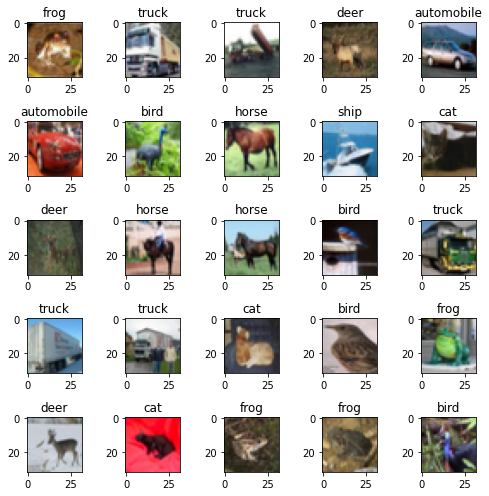

In [8]:
data = b1['data'].reshape(10000,3,32,32)
im_views = np.transpose(data, (0, 2, 3, 1))
fig, axs = plt.subplots(5,5,figsize=(7,7))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(im_views[i])
    ax.set_title(label_dict[b1['labels'][i]])
plt.tight_layout()


## Prepare the data

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 256 so that PyTorch can work with floating point numbers in (0,1).

In [11]:
def prep_training(filename="data_batch_",
                  folder=Path(r"../data/cifar-10-batches-py")):
    train_data = None
    train_y = None
    for i in np.arange(1, 6):
        batch = unpickle(folder/(filename + str(i)))
        if train_data is None:
            train_data = batch['data']
            train_y = batch['labels']
        else:
            train_data = np.concatenate((train_data, batch['data']))
            train_y = np.concatenate((train_y, batch['labels']))
    return torch.tensor(train_data).reshape(50000,3,32,32)/256, torch.tensor(train_y)

folder=Path(r"../data/cifar-10-batches-py")
test_imgs = torch.tensor(unpickle(folder/"test_batch")['data']).reshape(10000,3,32,32)/256
test_y = torch.tensor(unpickle(folder/"test_batch")['labels'])
train_imgs, train_y = prep_training()

label_names = b1_l['label_names']

In [12]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 3, 32, 32]),
 torch.Size([50000]),
 torch.Size([50000, 3, 32, 32]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [14]:
avg_img = torch.zeros((10,3,32,32))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

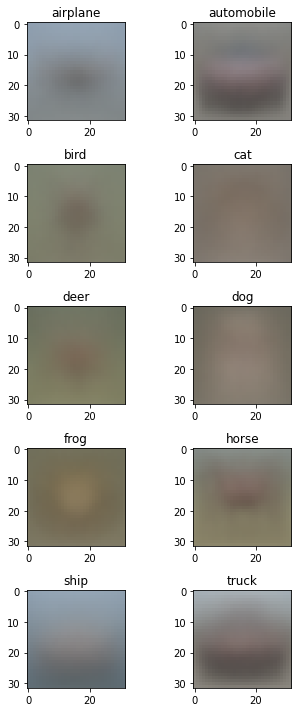

In [15]:
im = avg_img.permute(0,2,3,1)
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(im[i])
    ax.set_title(label_dict[i])
plt.tight_layout()

Test our benchmark prediction. 27%!! Pretty good for just calculating an average. We now need our neural net to outperform 27% accuracy to be any good.

In [18]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

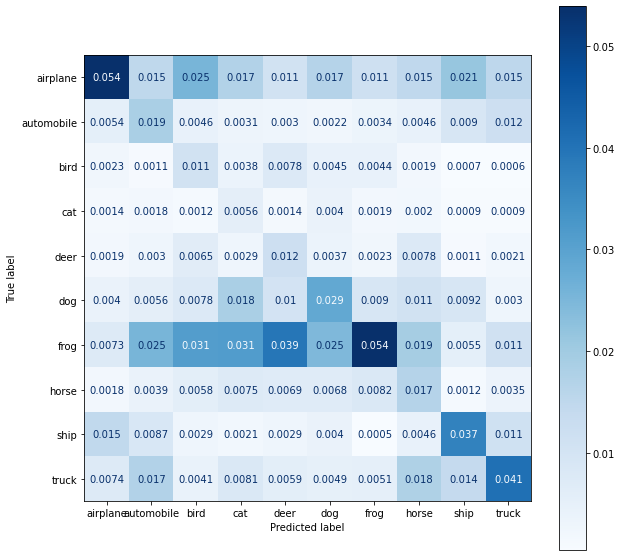

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import unique
display(unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_names
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)